# LangGraph: StateGraph Essentials

In [1]:
from utils import render_mermaid_remote
#from IPython.display import Image, display
#g_mermaid_cmd = graph.get_graph(xray=True).draw_mermaid()
#render_mermaid_remote(g_mermaid_cmd, False)

## State, Nodes
<img src="./Assets/States_Nodes.png" align="left" width="600" style="margin-right:15px;"/>


In [2]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langgraph.graph import END, START, StateGraph

from langgraph.types import Command, interrupt

In [3]:
class State(TypedDict):
    nlist : List[str]   

In [4]:
def node_a (state: State):
    print(f"node a is receiving {state['nlist']}")
    note = "Hello World from Node a"
    print (note)
    return({"nlist": [note]})

In [5]:
builder = StateGraph(State)
builder.add_node("a", node_a) 
builder.add_edge(START,"a")
builder.add_edge("a",END)
graph = builder.compile()

In [6]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

NameError: name 'Image' is not defined

In [7]:
initial_state = State(
    nlist = ["Hello Node a, how are you?"]
)
graph.invoke(initial_state)

node a is receiving ['Hello Node a, how are you?']
Hello World from Node a


{'nlist': ['Hello World from Node a']}

**What are the takeaways?**  
**Setup**:  
- State  
    - All nodes can share the same state
    - State can be any Python data type, but commonly is Typedict, dataclass or pydantic
- Nodes are just functions

**Execution (invoke)**
- Runtime
    - Initializes the input state from the invoke statement
    - determines which node(s) to run
- It provides the node with state as an input
- The node is executed and updates state with its return value
- The graph returns the final value of state.

**Try Next**
- add another node
- modify the the print or the intial state message
- Add another value to state
  


## Edges: Parallel Execution
<div style="display:flex; align-items:flex-start;">
  <img src="./Assets/Parallel.png" width="300" style="margin-right:15px;"/>
  <img src="./Assets/parallel_mermaid.png" width="150"/>
</div>

In [8]:
class State(TypedDict):
    nlist : Annotated[list[str], operator.add]   

In [9]:
def a (state: State):
    print(f'Adding "A" to {state["nlist"]}')
    return({"nlist": ["A"]})

In [10]:
def b (state: State):
    print(f'Adding "B" to {state["nlist"]}')
    return({"nlist": ["B"]})

In [11]:
def bb (state: State):
    print(f'Adding "BB" to {state["nlist"]}')
    return({"nlist": ["BB"]})

In [12]:
def c (state: State):
    print(f'Adding "C" to {state["nlist"]}')
    return({"nlist": ["C"]})

In [13]:
def cc (state: State):
    print(f'Adding "CC" to {state["nlist"]}')
    return({"nlist": ["CC"]})

In [14]:
def d (state: State):
    print(f'Adding "D" to {state["nlist"]}')
    return({"nlist": ["D"]})

In [16]:
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(bb)
builder.add_node(c)
builder.add_node(cc)
builder.add_node(d)
builder.add_edge(START,"a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "bb")
builder.add_edge("c", "cc")
builder.add_edge("bb", "d")
builder.add_edge("cc", "d")
builder.add_edge("d",END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

<div style="display:flex; align-items:flex-start;">
  <img src="./Assets/parallel_mermaid.png" width="200"/>
</div>

In [17]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding "A" to ['Initial String:']
Adding "B" to ['Initial String:', 'A']
Adding "C" to ['Initial String:', 'A']
Adding "BB" to ['Initial String:', 'A', 'B', 'C']
Adding "CC" to ['Initial String:', 'A', 'B', 'C']
Adding "D" to ['Initial String:', 'A', 'B', 'C', 'BB', 'CC']


{'nlist': ['Initial String:', 'A', 'B', 'C', 'BB', 'CC', 'D']}

<div style="font-size:16px; color:green;">

> **Note:**  
> The state passed to nodes 'bb' and 'cc' is the result of both nodes 'b' and 'c' storing their results to state.  
> Edges convey control, not data. Data is stored to state from all active nodes at the end of a step.

</div>


### What are the takeaways?  
**Setup**:  
- State  
    - You added a reducer function in the state definition
- Graph
    - You used .add_edge() to create parallel path

**Execution**
- Runtime
    - Nodes b and c operate in parallel.
    - uses the reducer function to merge the values returned
    - results from node b, c are stored to state before starting node bb and cc
        - Control follows edges, not data

**Result**
The final result had all the values added to nlist by all the nodes.

**Try Next**
- Try adding a 3rd parallel path
- Rather than joining at d, have bb and cc pass control to END. Are values still merged?


## Conditional Edges
<div style="display:flex; align-items:flex-start;">
  <img src="./Assets/Conditional.png" width="300" style="margin-right:15px;"/>
  <img src="./Assets/Conditional_mermaid.png" width="200"/>
</div>

In [18]:
class State(TypedDict):
    nlist : Annotated[list[str], operator.add]   

In [19]:
def na (state: State) -> Command[Literal["b", "c", END]]:

    select = state["nlist"][-1]
    if select == "b":
        next_node = "b"
    elif select == "c":
        next_node = "c"
    elif select == "q":
        next_node = END
    else:
        next_node = END
        
    return Command(
        update ={"nlist": [select]},
        goto=next_node
    )

In [20]:
def nb (state: State):
    return({"nlist": ["B"]})

In [21]:
def nc (state: State):
    return({"nlist": ["C"]})

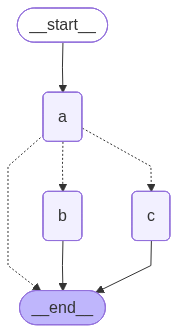

In [22]:
builder = StateGraph(State)
builder.add_node("a", na)
builder.add_node("b", nb)
builder.add_node("c", nc)
builder.add_edge(START,"a")
#
builder.add_edge("b", END)
builder.add_edge("c", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
user = input('b, c, or q to quit: ')

input_state = State(
    nlist = [user]
)
graph.invoke(input_state)

b, c, or q to quit:  b


{'nlist': ['b', 'b', 'B']}

In [25]:
while True:
    user = input('b, c, or q to quit: ')
    input_state = State(nlist = [user])
    result = graph.invoke(input_state)
    print( result )
    if result['nlist'][-1] == "q":
        print("quit")
        break

b, c, or q to quit:  c


{'nlist': ['c', 'c', 'C']}


b, c, or q to quit:  b


{'nlist': ['b', 'b', 'B']}


b, c, or q to quit:  q


{'nlist': ['q', 'q']}
quit


**What are the takeaways?**  
**Setup**:  
- Graph
    - You used Command in the return statement to update Both the state and the control path
    - Command 'goto' allows you to name the next node.
    - Note that you must be careful to match the destination node name. You can use pydantic to do some checking.
    - You must add the -> Command(..) as the node return type to allow the graphing software to understand how to draw the graph (it is not needed for functionality).

**Try Next**
- Try varying the input string to change the selection path.
- Try misnaming `next_node` to see the run-time error that results.


## Memory
<div style="display:flex; align-items:flex-start;">
  <img src="./Assets/Conditional_mermaid.png" width="150"/>
  <img src="./Assets/Memory.png" width="500" style="margin-right:15px;"/>
</div>

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}

In [30]:
graph = builder.compile(checkpointer=memory)

In [31]:
while True:
    user = input('b, c, or q to quit: ')
    input_state = State(nlist = [user])
    result = graph.invoke(input_state, config )
    print( result )
    if result['nlist'][-1] == "q":
        print("quit")
        break

b, c, or q to quit:  b


{'nlist': ['b', 'b', 'B']}


b, c, or q to quit:  c


{'nlist': ['b', 'b', 'B', 'c', 'c', 'C']}


b, c, or q to quit:  b


{'nlist': ['b', 'b', 'B', 'c', 'c', 'C', 'b', 'b', 'B']}


b, c, or q to quit:  q


{'nlist': ['b', 'b', 'B', 'c', 'c', 'C', 'b', 'b', 'B', 'q', 'q']}
quit


### What are the takeaways?  
**Setup**:  
- Memory
    - Instantiate a checkpoint memory 
- Graph
    - Build the graph with the checkpointer

**Execution**
- Runtime
    - invoke the graph with the thread id in the configuration

**Result**     
- You can invoke the graph, and between invocations, the state is preserved in checkpoint memory

**Try Next**
- Try running the graph yourself and observing the accumulation of values.


## Interrupt! Human In The Loop
<div style="display:flex; align-items:flex-start;">
  <img src="./Assets/Conditional_mermaid.png" width="150"/>
  <img src="./Assets/HITL.png" width="500" style="margin-right:15px;"/>
</div>

In [95]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}

In [96]:
class State(TypedDict):
    nlist : Annotated[list[str], operator.add]  

In [97]:
def na (state: State) -> Command[Literal["b", "c", END]]:

    print("Entered 'a' node")
    select = state["nlist"][-1]
    if select == "b":
        next_node = "b"
    elif select == "c":
        next_node = "c"
    elif select == "q":
        next_node = END
    else:
        admin = interrupt({"message": f"\U0001F4A5 Unexpected input {select}! Continue? "})
        print(admin)
        if admin == "continue":
            next_node = "b"
        else:
            next_node = END
            select = "q"
    return Command(
        update ={"nlist": [select]},
        goto=next_node
    )

In [98]:
def nb (state: State):
    return({"nlist": ["B"]})

In [99]:
def nc (state: State):
    return({"nlist": ["C"]})

In [100]:
builder = StateGraph(State)
builder.add_node("a", na)
builder.add_node("b", nb)
builder.add_node("c", nc)
builder.add_edge(START,"a")
#
builder.add_edge("b", END)
builder.add_edge("c", END)
graph = builder.compile(checkpointer=memory)

In [101]:
while True:
    user = input('b, c, or q to quit: ')
    input_state = State(nlist = [user])
    result = graph.invoke(input_state, config )    

    if '__interrupt__' in result:
        print(f"\033[31m{80*'-'}\033[0m")
        print(f"Interrupt:{result}")
        msg = result['__interrupt__'][-1].value['message']
        human = input(f"\n{msg}: ")

        human_response = Command(
            resume = human
        )
        result = graph.invoke(human_response, config )
        print(f"\033[31m{80*'-'}\033[0m")
    
    
    print( result )

    if result['nlist'][-1] == "q":
        print("quit")
        break

b, c, or q to quit:  x


Entered 'a' node
--------------------------------------------------------------------------------
Interrupt:{'nlist': ['x'], '__interrupt__': [Interrupt(value={'message': '💥 Unexpected input x! Continue? '}, id='477da7b00363e4c2c20c016221627bc0')]}



💥 Unexpected input x! Continue? :  quit


Entered 'a' node
quit
--------------------------------------------------------------------------------
{'nlist': ['x', 'q']}
quit


**What are the takeaways?**  

**Setup**  

- Graph
    - You add an `interrupt` statement
- Python runtime
    - add an interrupt handler
  
**Execution**
- When the interrupt is invoked, the operation pauses and the graph returns a value in an `__interrupt__` field.
- When the graph is `invoked` with a `Command` containing a `response`, a value is provided to the graph and operation continues.
- The node is restarted from the beginning. The Checkpointer will replay responses to interrupts.
  
**Try Next**
- Try returning more complex data in the `response`.
- Try adding additional interrupts to confirm the replay behavior.